In [1]:
import numpy as np
import sympy as sp
from latex2sympy2 import latex2sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

---
### **Riemann Sum Visualiser**

The following code implements the [Riemann sum](https://en.wikipedia.org/wiki/Riemann_sum) of a function $f(x)$, over an interval with bounds $a$ and $b$, number of partitions $N$ and sampling rule $v \in [0,1]$ (where $v=0$ implements the right rule, and $v=1$ implements the left rule. This is all expressed in this formula:
$$S(f, a, b, N, v) = \sum_{n=1}^N \Delta x f\left( a + (n-v)\Delta x \right), \quad\quad \Delta x = \frac{b-a}{N}.$$
For the area between two curves, $f_1(x)$ and $f_2(x)$, the formula becomes
$$S(f_1, f_2, a, b, N, v) = \sum_{n=1}^N \Delta x \bigg( f_1\left( a + (n-v)\Delta x \right) - f_1\left( a + (n-1+v)\Delta x \right) \bigg), \quad\quad \Delta x = \frac{b-a}{N}.$$
Where the complement rule $1-v$ is used as the sampling point for $f_2$ (purely because it looks nicer).

In [2]:
def rebrighten(colour, value):
    r, g, b = to_rgb(colour)
    return (r*value, g*value, b*value)

In [3]:
def riemann_sum(
    func_1='x-axis', func_2='x-axis', lower=0, upper=1, n_strips=10, 
    rule=0.5, samples=1000, y_lims=None, extend_x=True, pattern='counting', 
    equal=False, title_1_pos=0.28, title_2_pos=0.72, title_size=40, 
    title_y=1.055, save=False, file_type='gif', title='Riemann Sum', fps=5
):

    # creating function arrays

    x_axis = [0] * samples

    if extend_x:
        x_extra = 0.2 * abs(upper - lower)
    else:
        x_extra = 0
        
    if lower < upper:
        x_vals = np.linspace(lower-x_extra, upper+x_extra, samples)
    elif lower > upper:
        x_vals = np.linspace(lower+x_extra, upper-x_extra, samples)
        
    x = sp.symbols('x')

    y_1 = x_axis
    if func_1 != 'x-axis':
        expr_1 = latex2sympy(func_1)
        f_1 = sp.lambdify(x, expr_1, modules='numpy')
        y_1 = f_1(x_vals)

    y_2 = x_axis
    if func_2 != 'x-axis':
        expr_2 = latex2sympy(func_2)
        f_2 = sp.lambdify(x, expr_2, modules='numpy')
        y_2 = f_2(x_vals)

    # plot initialisation
    
    x_min, x_max = min(x_vals), max(x_vals)

    if y_lims is None:
        y_lower = min(min(y_1), min(y_2))
        y_upper = max(max(y_1), max(y_2))
        y_padding = 0.2 * abs(y_upper - y_lower)
        y_min = y_lower - y_padding
        y_max = y_upper + y_padding

    plt.style.use('dark_background')

    if not equal:
        fig, ax = plt.subplots(figsize=[16, 8])
        
        if extend_x:
            ax.set_xlim([x_min, x_max])
            
        if y_lims is None:
            ax.set_ylim([y_min, y_max])
        else:
            ax.set_ylim(y_lims)
    else:
        fig, ax = plt.subplots(figsize=[16, 16])
        
        global_min = min(x_min, y_min)
        global_max = max(x_max, y_max)

        ax.set_xlim([global_min, global_max])
        ax.set_ylim([global_min, global_max])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    ax.axhline(0, alpha=0.3, zorder=-1)
    ax.axvline(0, alpha=0.3, zorder=-1)

    ax.axvline(lower, linestyle='--', color='yellow', linewidth=2, alpha=0.5)
    ax.axvline(upper, linestyle='--', color='yellow', linewidth=2, alpha=0.5)

    if not np.array_equal(y_1, x_axis):
        ax.plot(x_vals, y_1, color='crimson', linewidth=2)
        
    if not np.array_equal(y_2, x_axis):
        ax.plot(x_vals, y_2, color='orangered', linewidth=2)

    if lower == round(lower, 3):
        a = lower
    else:
        a = round(lower, 3)
        
    if upper == round(upper, 3):
        b = upper
    else:
        b = round(upper, 3)

    # plotting strips

    titles = []
    
    def update(frame):

        for artist in list(ax.artists):
            artist.remove()
        for patch in list(ax.patches):
            patch.remove()
        for title in titles:
            title.remove()
        titles.clear()

        strips = []
        area = 0

        if pattern == 'counting':
            current_n = frame + 1
        elif pattern == 'doubling':
            current_n = 2**frame

        width = (upper - lower) / current_n

        for n in range(1, current_n+1):

            target_1 = lower + (n - rule) * width
            target_2 = lower + (n - 1 + rule) * width

            index_1 = min(range(len(x_vals)), key=lambda i: abs(x_vals[i]-target_1))
            index_2 = min(range(len(x_vals)), key=lambda i: abs(x_vals[i]-target_2))
            
            height = y_1[index_1] - y_2[index_2]
            xy = (lower + (n-1) * width, y_2[index_2])

            single_area = width * height
            area += single_area

            if single_area < 0:
                strip_col = rebrighten('midnightblue', 1.2)
            elif single_area >= 0:
                strip_col = rebrighten('midnightblue', 0.8)

            strip = Rectangle(xy, width, height,
                              facecolor=strip_col,
                              edgecolor='midnightblue', linewidth=0.8)

            ax.add_patch(strip)
            strips.append(strip)
                
        t1 = ax.text(0, 1.055, f'Upper bound = {b}', color=rebrighten('yellow', 0.8), 
                     fontsize=20, ha='left', va='bottom', transform=ax.transAxes)
        t2 = ax.text(0, 1.055, f'Lower bound = {a}', color=rebrighten('yellow', 0.8), 
                     fontsize=20, ha='left', va='top', transform=ax.transAxes)

        if not np.array_equal(y_1, x_axis) and not np.array_equal(y_2, x_axis):
            t3 = ax.text(title_1_pos, title_y, f'$f_1(x) = {func_1}$', color='crimson', 
                         fontsize=title_size, ha='left', va='center', transform=ax.transAxes)
            t4 = ax.text(title_2_pos, title_y, f'$f_2(x) = {func_2}$', color='orangered', 
                         fontsize=title_size, ha='right', va='center', transform=ax.transAxes)
            
        elif not np.array_equal(y_1, x_axis) and np.array_equal(y_2, x_axis):
            t3 = ax.text(0.5, title_y, f'$f(x) = {func_1}$', color='crimson', fontsize=40,
                         ha='center', va='center', transform=ax.transAxes)
            t4 = ax.text(0, 0, '')
        
        elif np.array_equal(y_1, x_axis) and not np.array_equal(y_2, x_axis):
            t3 = ax.text(0, 0, '')
            t4 = ax.text(0.5, title_y, f'$f(x) = {func_2}$', color='orangered', fontsize=40,
                         ha='center', va='center', transform=ax.transAxes)
        
        t5 = ax.text(1, 1.055, f'{n}-strip approximation', 
                     color=rebrighten('midnightblue', 1.8), ha='right', va='bottom', 
                     fontsize=20, transform=ax.transAxes)
        t6 = ax.text(1, 1.055, f'{area:.5g}', 
                     color=rebrighten('midnightblue', 1.8), ha='right', va='top', 
                     fontsize=20, transform=ax.transAxes)

        titles.extend([t1, t2, t3, t4, t5, t6])

        return strips

    # making animation
    
    if pattern == 'counting':
        frames = n_strips
    elif pattern == 'doubling':
        frames = round(np.log2(n_strips))

    if file_type == 'png':
        
        final_frame = frames - 1
        
        update(final_frame)
    
        if save:
            fig.savefig(f'{title}.png', dpi=300)
 
        return

    anim = FuncAnimation(fig, update, frames=frames, blit=False)

    if save:
        anim.save(f'{title}.{file_type}', writer=PillowWriter(fps=fps))

    plt.close(fig)
    
    return HTML(anim.to_jshtml())

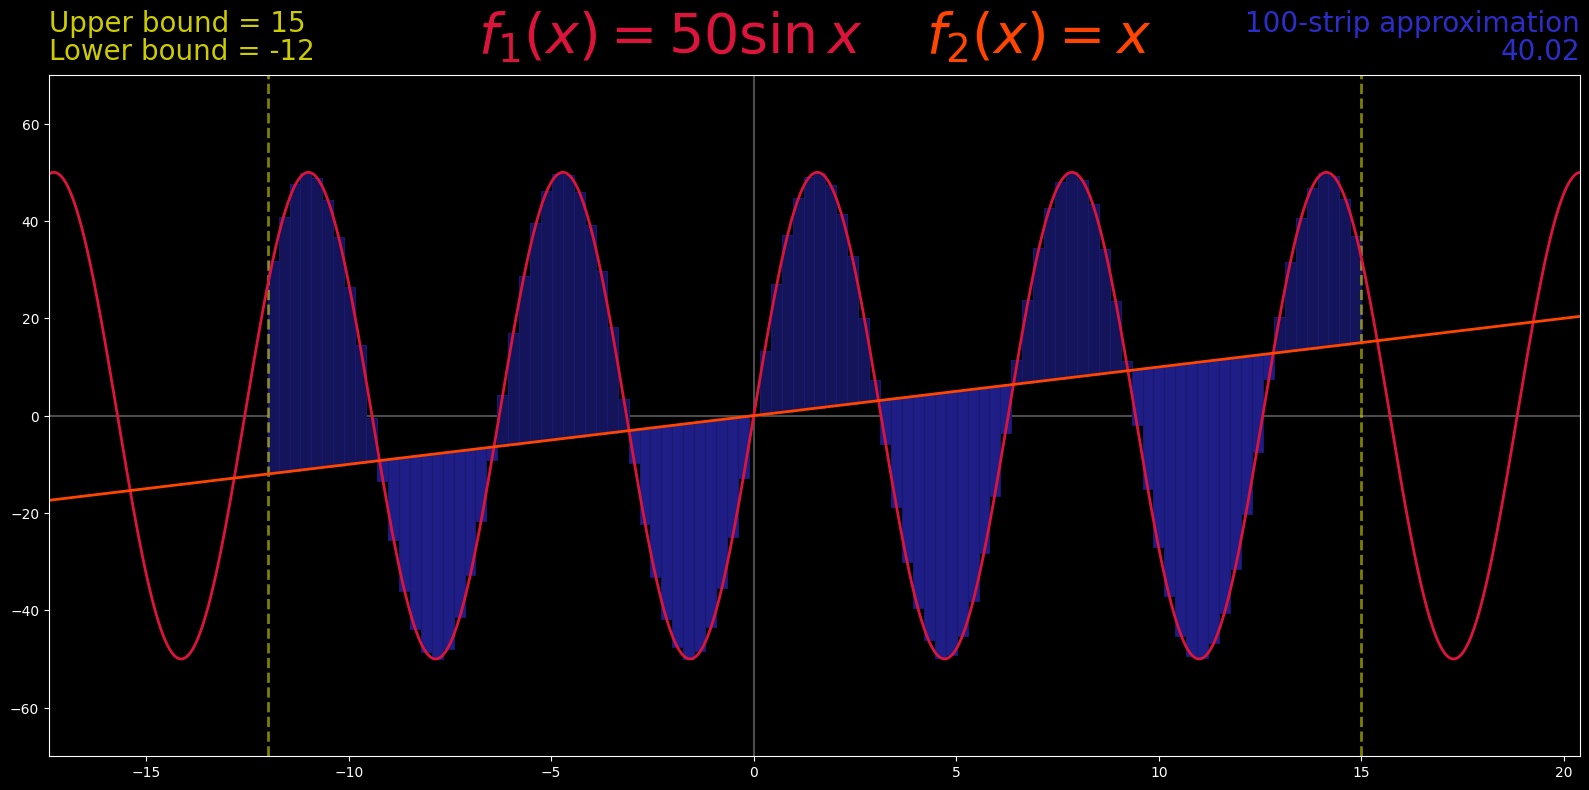

In [4]:
riemann_sum(lower=-12, upper=15, func_1=r'50 \sin x', func_2=r'x', n_strips=100, rule=0.5,
           save=False, title='50sinx_x', file_type='png')

In [5]:
def void_RS(
    func_1='x-axis', func_2='x-axis', lower=0, upper=1, n_strips=10, 
    rule=0.5, samples=1000, y_lims=None, pattern='counting', 
    paint='rolling', title_1_pos=0.28, title_2_pos=0.72, title_size=40, 
    save=False, file_type='gif', title='Riemann Sum', fps=5
):

    # creating function arrays

    x_axis = [0] * samples
    x_vals = np.linspace(lower, upper, samples)
    x = sp.symbols('x')

    y_1 = x_axis
    if func_1 != 'x-axis':
        expr_1 = latex2sympy(func_1)
        f_1 = sp.lambdify(x, expr_1, modules='numpy')
        y_1 = f_1(x_vals)

    y_2 = x_axis
    if func_2 != 'x-axis':
        expr_2 = latex2sympy(func_2)
        f_2 = sp.lambdify(x, expr_2, modules='numpy')
        y_2 = f_2(x_vals)

    # plot initialisation
    
    x_lower = min(x_vals)
    x_upper = max(x_vals)
    x_padding = 0.1 * abs(x_upper - x_lower)
    x_min = x_lower - x_padding
    x_max = x_upper + x_padding

    if y_lims is None:
        y_lower = min(min(y_1), min(y_2))
        y_upper = max(max(y_1), max(y_2))
        y_padding = 0.1 * abs(y_upper - y_lower)
        y_min = y_lower - y_padding
        y_max = y_upper + y_padding

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=[16, 8])
    ax.set_aspect('equal')
    ax.set_axis_off()

    ax.set_xlim([x_min, x_max])
    if y_lims is None:
        ax.set_ylim([y_min, y_max])
    else:
        ax.set_ylim(y_lims)

    plt.tight_layout()

    # plotting strips

    colours = plt.cm.rainbow(np.linspace(1, 0, n_strips))
    
    def update(frame):

        for artist in list(ax.artists):
            artist.remove()
        for patch in list(ax.patches):
            patch.remove()

        strips = []

        if pattern == 'counting':
            current_n = frame + 1
        elif pattern == 'doubling':
            current_n = 2**frame

        width = (upper - lower) / current_n

        for n in range(1, current_n+1):

            target_1 = lower + (n - rule) * width
            target_2 = lower + (n - 1 + rule) * width

            index_1 = min(range(len(x_vals)), key=lambda i: abs(x_vals[i]-target_1))
            index_2 = min(range(len(x_vals)), key=lambda i: abs(x_vals[i]-target_2))
            
            height = y_1[index_1] - y_2[index_2]
            xy = (lower + (n-1) * width, y_2[index_2])
            
            if paint == 'rolling': 
                colour = colours[n-1]
            elif paint == 'emerging':
                if current_n == 1:
                    index = round(n_strips / 2)
                else:
                    index = round((n - 1) * (len(colours) - 1) / (current_n - 1))
                colour = colours[index]
                
            strip = Rectangle(xy, width, height, facecolor=colour, edgecolor=colour)
            
            ax.add_patch(strip)
            strips.append(strip)

        return strips

    # making animation
    
    if pattern == 'counting':
        frames = n_strips
    elif pattern == 'doubling':
        frames = round(np.log2(n_strips))

    if file_type == 'png':
        
        final_frame = frames - 1
        update(final_frame)
    
        if save:
            fig.savefig(f'{title}.png', dpi=300)
 
        return

    anim = FuncAnimation(fig, update, frames=frames, blit=False)

    if save:
        anim.save(f'{title}.{file_type}', writer=PillowWriter(fps=fps))

    plt.close(fig)
    
    return HTML(anim.to_jshtml())